Support Giải thích code for: Nguyễn Ngọc Kim Trang - Deep Learning - https://www.facebook.com/NguyenNgocKimTrang

Link Kaggle: https://www.kaggle.com/code/nguyenchang/road-sign-detection-fasterrcnn-pytorch - copy from: https://www.kaggle.com/code/killa92/road-sign-detection-fasterrcnn-pytorch

### Hiểu bộ dataset và dataloader
- Thư mục annotations: Chứa các file annotation XML (đuôi .xml)
```
<annotation>
    <folder>images</folder>
    <filename>road0.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>98</xmin>
            <ymin>62</ymin>
            <xmax>208</xmax>
            <ymax>232</ymax>
        </bndbox>
    </object>
</annotation>
```
- Với boundingbox:
    - xmin: Tọa độ x của điểm trái trên cùng của bounding box
    - ymin: Tọa độ y của điểm trái trên cùng của bounding box
    - xmax: Tọa độ x của điểm phải dưới cùng của bounding box
    - ymax: Tọa độ y của điểm phải dưới cùng của bounding box
- Thư mục images: Chứa các file ảnh (đuôi .jpg, .png, .jpeg)


### Datasets and DataLoaders

In [ ]:
!pip install xmltodict
import os, cv2, random, xmltodict, torch, pandas as pd, numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from matplotlib import pyplot as plt

class ObjectDetectionCustomDataset(Dataset):
    """
    Kế thừa từ Dataset của PyTorch.
    Khởi tạo dataset từ các file annotation XML.
    - Đọc và xử lý thông tin về ảnh và bounding box.
    - Cung cấp các phương thức để lấy thông tin ảnh, tọa độ bounding box, và tạo mục tiêu cho mô hình.
    """
    def __init__(self, root, transformations = None, size = 224, im_files = [".jpg", ".png", ".jpeg"]):
        self.root, self.size, self.transformations = root, size, transformations
        self.class_names, self.class_counts = {}, 1
        self.data_info = sorted(glob(f"{root}/annotations/*.xml"))

        for idx, data_info in enumerate(self.data_info):

            info = xmltodict.parse(open(f"{data_info}","r").read())

            bbox_info = info["annotation"]["object"]
            if isinstance(bbox_info, list):
                for bb_info in bbox_info:
                    if class_name not in self.class_names: self.class_names[class_name] = self.class_counts; self.class_counts += 1

            elif isinstance(bbox_info, dict):
                for bb_info in bbox_info:
                    class_name = bbox_info["name"]
                    if class_name not in self.class_names: self.class_names[class_name] = self.class_counts; self.class_counts += 1

    def __len__(self): return len(self.data_info)

    def get_info(self, idx): return xmltodict.parse(open(f"{self.data_info[idx]}","r").read())

    def read_im(self, info): return Image.open(f"{self.root}/images/{info['annotation']['filename']}").convert("RGB")

    def get_coordinates(self, bbox): return float(bbox["xmin"]), float(bbox["ymin"]), float(bbox["xmax"]), float(bbox["ymax"])

    def get_bboxes(self, info):
        # Hàm get_bboxes sẽ trích xuất tọa độ bounding box và tên lớp từ các file annotation XML (đuôi .xml)

        bboxes, class_names = [], []
        bbox_info = info["annotation"]["object"]

        if isinstance(bbox_info, list):
            for bb_info in bbox_info:
                bbox = bb_info["bndbox"]
                class_name = bb_info["name"]
                class_names.append(class_name)
                bboxes.append(self.get_coordinates(bbox))

        elif isinstance(bbox_info, dict):
            for bb_info in bbox_info:
                if bb_info == "bndbox":
                    bbox = bbox_info[bb_info]
                    class_name = bbox_info["name"]
                    bboxes.append(self.get_coordinates(bbox))
                    class_names.append(class_name)

        return torch.as_tensor(bboxes, dtype = torch.float32), class_names

    def get_label(self, class_name): return self.class_names[class_name]

    def get_area(self, bboxes): return (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])

    def create_target(self, bboxes, labels, rasm_id, area, is_crowd): target = {}; target["boxes"] = bboxes; target["labels"] = labels; target["image_id"] = rasm_id; target["area"] = area; target["iscrowd"] = is_crowd; return target

    def __getitem__(self, idx):

        info = self.get_info(idx)
        im = self.read_im(info)
        bboxes, class_names = self.get_bboxes(info)
        labels = torch.tensor([self.get_label(class_name) for class_name in class_names], dtype = torch.int64)

        rasm_id = torch.tensor([idx])
        area = self.get_area(bboxes)
        is_crowd = torch.zeros((len(bboxes), ), dtype = torch.int64)

        target = self.create_target(bboxes, labels, rasm_id, area, is_crowd)

        if self.transformations is not None: im, target = self.transformations(im, target)

        return im, target

def custom_collate_fn(batch): return tuple(zip(*batch)) # Hàm này được sử dụng để đóng gói các mẫu dữ liệu thành các batch.

def get_dls(root, transformations, bs, split = [0.8, 0.1], ns = 4):
    """_summary_: Tạo dataloader cho tập huấn luyện, kiểm định và kiểm tra

    Args:
        root (str): Đường dẫn đến thư mục chứa dữ liệu
        transformations (torchvision.transforms.Compose): Biến đổi dữ liệu
        bs (int): Kích thước batch: Chỉ định số lượng mẫu dữ liệu được xử lý cùng một lúc trong một lần huấn luyện.
                Ví dụ: Nếu bs=4, mô hình sẽ nhận 4 mẫu dữ liệu trong mỗi lần cập nhật trọng số.
        split (list, optional): Tỉ lệ chia dữ liệu huấn luyện, kiểm định và kiểm tra. Defaults to [0.8, 0.1].
        ns (int, optional): Số lượng worker: Chỉ định số lượng luồng (worker) được sử dụng để nạp dữ liệu song song.

    Returns:
        tuple: Dataloader cho tập huấn luyện, kiểm định và kiểm tra
    """

    ds = ObjectDetectionCustomDataset(root = root, transformations = transformations)

    all_len = len(ds); tr_len = int(all_len * split[0]); val_len = int(all_len * split[1])
    tr_ds, val_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, val_len, all_len - tr_len - val_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, collate_fn = custom_collate_fn, shuffle = True, num_workers = ns), DataLoader(val_ds, batch_size = bs, collate_fn = custom_collate_fn, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, collate_fn = custom_collate_fn, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.class_names

  Obtaining dependency information for xmltodict from https://files.pythonhosted.org/packages/83/33/ce3c404fece93880135ab9a07414d57f642e9340717130362bcd4ecee3c1/xmltodict-0.14.1-py2.py3-none-any.whl.metadata


### Transformations

Định nghĩa các lớp và hàm để thực hiện biến đổi dữ liệu cho bài toán phát hiện đối tượng.

1. Các lớp chính:
    - Compose: Kết hợp nhiều biến đổi
    - PILToTensor: Chuyển ảnh PIL sang Tensor
    - Normalize: Chuẩn hóa ảnh
    - ConvertImageDtype: Đổi kiểu dữ liệu ảnh
    - RandomHorizontalFlip: Lật ngang ảnh ngẫu nhiên

2. Hàm get_transform tạo chuỗi biến đổi cho huấn luyện và kiểm tra.

3. Cuối cùng, tạo bộ dữ liệu và dataloader cho tập huấn luyện, kiểm định và kiểm tra.

 Đoạn code này quan trọng trong việc chuẩn bị dữ liệu cho mô hình học máy, đặc biệt cho bài toán phát hiện biển báo giao thông.

In [ ]:
from torch import Tensor
from torchvision.transforms import functional as F, transforms as T
from typing import Dict, Optional, Tuple, List

class Compose:
    """
    Kế thừa từ torchvision.transforms.Compose.
    Áp dụng một chuỗi các biến đổi cho ảnh và mục tiêu.
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class PILToTensor(torch.nn.Module): # Chuyển đổi ảnh PIL sang Tensor
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.pil_to_tensor(image)
        return image, target

class Normalize(torch.nn.Module): # Chuẩn hóa ảnh
    def forward(self, image: Tensor, target: Optional, mean: List[float] = [0.485, 0.456, 0.406], std: List[float] = [0.229, 0.224, 0.225]):
        image = F.normalize(tensor = image, mean = mean, std = std)
        return image, target

class ConvertImageDtype(torch.nn.Module): # Đổi kiểu dữ liệu ảnh từ float32 sang float16
    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.convert_image_dtype(image, self.dtype)
        return image, target

class RandomHorizontalFlip(T.RandomHorizontalFlip): # Lật ngang ảnh ngẫu nhiên
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                _, _, width = F.get_dimensions(image)
                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
        return image, target

def get_transform(train): # Tạo chuỗi biến đổi cho huấn luyện và kiểm tra

    transformations = []
    transformations.append(PILToTensor())
    transformations.append(ConvertImageDtype(torch.float))
    transformations.append(Normalize())

    if train: transformations.append(RandomHorizontalFlip(0.5))

    return Compose(transformations)

tfs = get_transform(train = False)
data_path = "/kaggle/input/road-sign-detection"
tr_dl, val_dl, ts_dl, class_names = get_dls(root = data_path, transformations = tfs, bs = 4)
print(len(tr_dl), len(val_dl), len(ts_dl), class_names)

176 22 89 {'trafficlight': 0, 'speedlimit': 1, 'crosswalk': 2, 'stop': 3}


 1. Batch size (bs=4):
    - Mỗi batch chứa 4 mẫu dữ liệu
    - Giúp tăng tốc độ huấn luyện, quản lý bộ nhớ và cải thiện độ ổn định
 2. Number of workers (ns=4):
    - Chỉ định số lượng luồng (worker) được sử dụng để nạp dữ liệu song song.
 3. Số lượng batch:
    - Tập training: 80% mẫu dữ liệu từ hơn 877 ảnh => 702 ảnh => 702 / 4 = 176 batch
    - Tập validation: 10% mẫu dữ liệu từ hơn 877 ảnh => 88 ảnh => 88 / 4 = 22 batch
    - Tập test: 10% mẫu dữ liệu từ hơn 877 ảnh => 88 ảnh => 88 / 1 = 88 batch
   Vì bên trên:
   ```
       tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, collate_fn = custom_collate_fn, shuffle = True, num_workers = ns), DataLoader(val_ds, batch_size = bs, collate_fn = custom_collate_fn, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, collate_fn = custom_collate_fn, shuffle = False, num_workers = ns)
   ```

 4. Danh sách lớp trong bộ dữ liệu:
    - trafficlight: 0
    - speedlimit: 1
    - crosswalk: 2
    - stop: 3

### Data Visualization

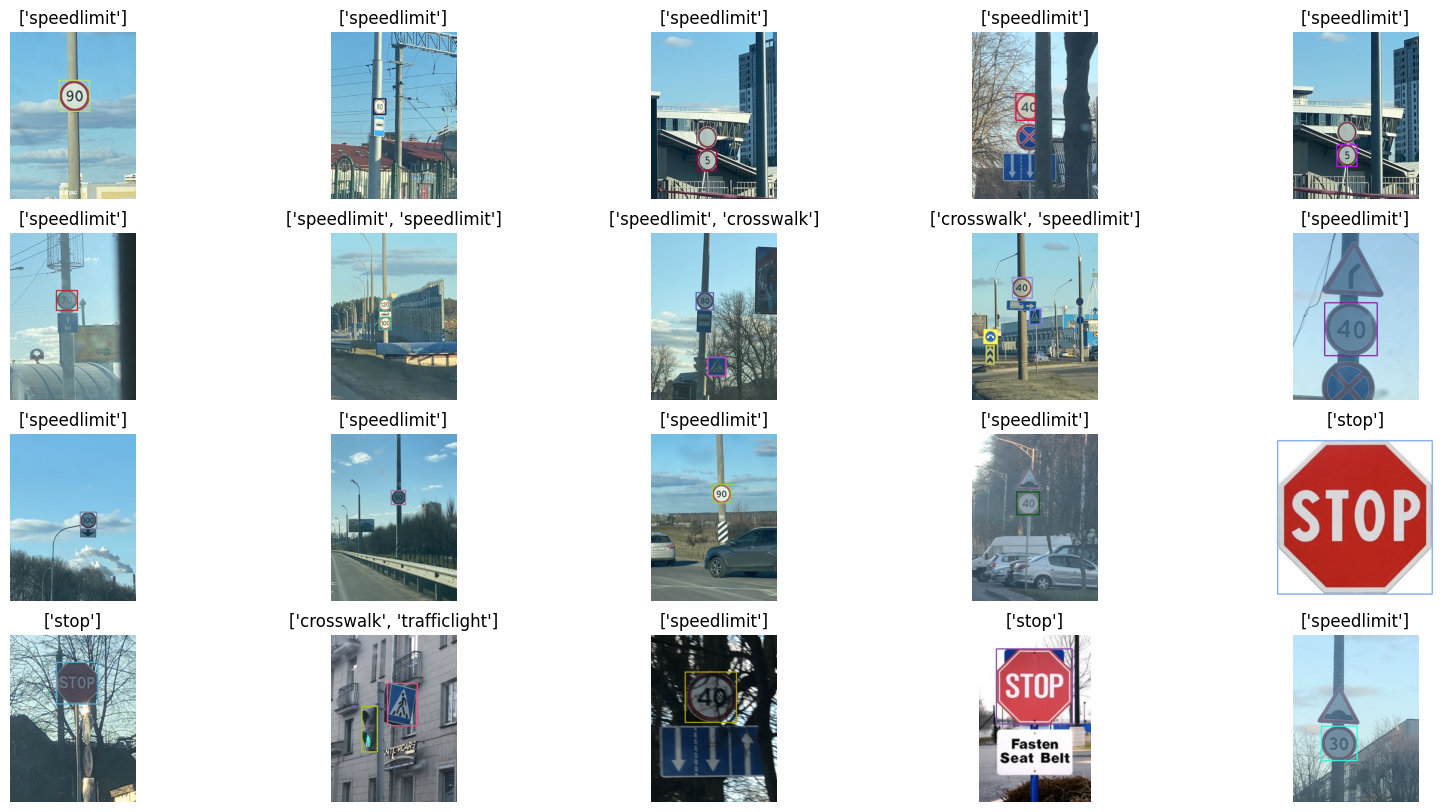

In [ ]:
def tensor_2_im(t, t_type = "rgb", inv_trans = False):

    assert t_type in ["rgb", "gray"], "Rasm RGB yoki grayscale ekanligini aniqlashtirib bering."
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs  = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if inv_trans else (t * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        im, target = data[indeks]
        img = tensor_2_im(im, inv_trans = True)
        bbox_class_names = []
        for i, cntr in enumerate(target["boxes"]):
            r, g, b = [random.randint(0, 255) for _ in range(3)]
            x, y, w, h = [round(c.item()) for c in cntr]
            bbox_class_names.append(list(class_names.keys())[target["labels"][i].item()])
            cv2.rectangle(img = img, pt1 = (x, y), pt2 = (w, h), color = (r, g, b), thickness = 2)
        bbox_class_names = [bbox_class_name for bbox_class_name in bbox_class_names]
        plt.subplot(rows, n_ims // rows, idx + 1)

        plt.imshow(img); plt.title(f"{bbox_class_names}")

        plt.axis("off")

visualize(tr_dl.dataset, 20, 4, "rgb")

### AI Model

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

m = fasterrcnn_resnet50_fpn(weights = "DEFAULT")
device, num_classes = "cuda", len(class_names)

# get number of input features for the classifier
in_features = m.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
m.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features, num_classes)
m.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(in_features, num_classes * 4)
m.to(device)
optimizer = torch.optim.SGD(m.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 250MB/s]  


### Evaluation Metrics

In [ ]:
!pip install pycocotools
import torch.distributed as dist, datetime
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as mask_util
from contextlib import redirect_stdout
import copy, io

class CocoEvaluator:
    def __init__(self, coco_gt, iou_types):
        if not isinstance(iou_types, (list, tuple)):
            raise TypeError(f"This constructor expects iou_types of type list or tuple, instead  got {type(iou_types)}")
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            with redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate_coco(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print(f"IoU metric: {iou_type}")
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        if iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        if iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        raise ValueError(f"Unknown iou type {iou_type}")

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "keypoints": keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


def evaluate_coco(imgs):
    with redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    data_list = [None] * world_size
    dist.all_gather_object(data_list, data)
    return data_list

  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/6a/03/6c0bf810a5df7876caaf11f5b113e7ffd4b2fa9767d360489c6fdcefe8e5/pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 15.3 MB/s eta 0:00:00


In [ ]:
import math, sys, time, torch, torchvision
import torchvision.models.detection.mask_rcnn
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from collections import defaultdict, deque

def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {"images": [], "categories": [], "annotations": []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict["id"] = image_id
        img_dict["height"] = img.shape[-2]
        img_dict["width"] = img.shape[-1]
        dataset["images"].append(img_dict)
        bboxes = targets["boxes"].clone()
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets["labels"].tolist()
        areas = targets["area"].tolist()
        iscrowd = targets["iscrowd"].tolist()
        if "masks" in targets:
            masks = targets["masks"]
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if "keypoints" in targets:
            keypoints = targets["keypoints"]
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann["image_id"] = image_id
            ann["bbox"] = bboxes[i]
            ann["category_id"] = labels[i]
            categories.add(labels[i])
            ann["area"] = areas[i]
            ann["iscrowd"] = iscrowd[i]
            ann["id"] = ann_id
            if "masks" in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if "keypoints" in targets:
                ann["keypoints"] = keypoints[i]
                ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])
            dataset["annotations"].append(ann)
            ann_id += 1
    dataset["categories"] = [{"id": i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds

def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler = None):
    model.train()
    metric_logger = MetricLogger(delimiter=" | ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"{epoch + 1}-epochdagi "

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for idx, (images, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images = list(image.to(device) for image in images)

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # change here

        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss {loss_value} bo'lgani uchun train jarayonini to'xtatamiz...")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

# @torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter=" | ")
    header = "Test jarayoni: "

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):

        images = list(img.to(device) for img in images)

        if torch.cuda.is_available(): torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_vaqt=model_time, baholash_vaqt=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print(f"\nTest jarayoni statistikasi: {metric_logger}\n")
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    return coco_evaluator

class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )

class MetricLogger:
    def __init__(self, delimiter=" | "):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            init_msg = "".join(
                [
                    f"\n{header}",
                    "{1}ta batchdan {0" + space_fmt +"}-sining natijasi: \n",
                ]
            )

            log_msg = self.delimiter.join(
                [
                    "{meters}",
                    "vaqt -> {time}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "vaqt: {vaqt}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(init_msg.format(i + 1, len(iterable)))
                    print(
                        log_msg.format(
                            meters=str(self),
                            time=str(iter_time),
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} umumiy vaqt: {total_time_str} ({total_time / len(iterable):.4f} s / rasm)")

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

### Train and Validation

In [ ]:
model_prefix = "road"
epochs = 1
save_model_path = "saved_models"
for epoch in range(epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(m, optimizer, tr_dl, device, epoch, print_freq = 10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(m, val_dl, device = device)

os.makedirs(f"{save_model_path}", exist_ok = True)
torch.save(m, f"{save_model_path}/{model_prefix}_best_model.pt")
print("Train jarayoni yakunlandi!")


1-epochdagi 176ta batchdan   1-sining natijasi: 

lr: 0.000002 | loss: 0.2764 (0.2764) | loss_classifier: 0.1687 (0.1687) | loss_box_reg: 0.0883 (0.0883) | loss_objectness: 0.0157 (0.0157) | loss_rpn_box_reg: 0.0037 (0.0037) | vaqt -> 1.0679

1-epochdagi 176ta batchdan  11-sining natijasi: 

lr: 0.000014 | loss: 0.2598 (0.2946) | loss_classifier: 0.1382 (0.1671) | loss_box_reg: 0.0883 (0.1025) | loss_objectness: 0.0157 (0.0193) | loss_rpn_box_reg: 0.0042 (0.0057) | vaqt -> 0.6360

1-epochdagi 176ta batchdan  21-sining natijasi: 

lr: 0.000027 | loss: 0.3094 (0.3027) | loss_classifier: 0.1621 (0.1696) | loss_box_reg: 0.1037 (0.1069) | loss_objectness: 0.0155 (0.0199) | loss_rpn_box_reg: 0.0042 (0.0062) | vaqt -> 0.6178

1-epochdagi 176ta batchdan  31-sining natijasi: 

lr: 0.000040 | loss: 0.3190 (0.3046) | loss_classifier: 0.1795 (0.1691) | loss_box_reg: 0.1125 (0.1101) | loss_objectness: 0.0152 (0.0196) | loss_rpn_box_reg: 0.0036 (0.0059) | vaqt -> 0.6274

1-epochdagi 176ta batchdan 

Các chỉ số **Average Recall (AR)** trong kết quả đánh giá mô hình phát hiện đối tượng được trình bày như sau:

1. **AR @[ IoU=0.50:0.95 | area=small | maxDets=100 ] = 0.173**:
   - Độ nhạy trung bình cho các đối tượng nhỏ, với IoU từ 0.50 đến 0.95, và tối đa 100 dự đoán được xem xét.
   - Giá trị 0.173 cho thấy mô hình phát hiện được 17.3% các đối tượng nhỏ.

2. **AR @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.253**:
   - Độ nhạy trung bình cho các đối tượng vừa, với cùng điều kiện về IoU và số lượng dự đoán.
   - Giá trị 0.253 cho thấy mô hình phát hiện được 25.3% các đối tượng vừa.

3. **AR @[ IoU=0.50:0.95 | area=large | maxDets=100 ] = 0.165**:
   - Độ nhạy trung bình cho các đối tượng lớn, với cùng điều kiện.
   - Giá trị 0.165 cho thấy mô hình phát hiện được 16.5% các đối tượng lớn.

### Tóm lại
Các chỉ số này cho thấy hiệu suất của mô hình trong việc phát hiện các đối tượng với kích thước khác nhau, từ nhỏ đến lớn, với các ngưỡng IoU khác nhau. Mô hình có độ nhạy cao hơn cho các đối tượng vừa so với các đối tượng nhỏ và lớn.

Trong ngữ cảnh đánh giá mô hình phát hiện đối tượng (object detection), có một số chỉ số (metrics) quan trọng thường được sử dụng để đo lường hiệu suất của mô hình. Dưới đây là một số chỉ số phổ biến:

### 1. **Precision (Độ chính xác)**:
   - Tỷ lệ giữa số lượng dự đoán đúng (true positives) và tổng số dự đoán (true positives + false positives).
   - Công thức:
     \[
     \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
     \]

### 2. **Recall (Độ nhạy)**:
   - Tỷ lệ giữa số lượng dự đoán đúng và tổng số đối tượng thực sự (true positives + false negatives).
   - Công thức:
     \[
     \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
     \]

### 3. **Average Precision (AP)**:
   - Đo lường độ chính xác trung bình tại nhiều ngưỡng độ tin cậy khác nhau.
   - Thường được tính cho các giá trị IoU (Intersection over Union) khác nhau (ví dụ: AP@IoU=0.5, AP@IoU=0.75).

### 4. **Mean Average Precision (mAP)**:
   - Trung bình của các giá trị AP cho tất cả các lớp và các ngưỡng IoU khác nhau.
   - Là một chỉ số tổng quát để đánh giá hiệu suất của mô hình.

### 5. **IoU (Intersection over Union)**:
   - Đo lường mức độ trùng lặp giữa bounding box dự đoán và bounding box thực tế.
   - Công thức:
     \[
     \text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
     \]

### 6. **F1 Score**:
   - Là trung bình điều hòa giữa Precision và Recall.
   - Công thức:
     \[
     F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
     \]

### 7. **Average Recall (AR)**:
   - Tính toán độ nhạy trung bình tại nhiều ngưỡng khác nhau của số lượng phát hiện tối đa (maxDets).

### Tóm lại
Các chỉ số này giúp đánh giá hiệu suất của mô hình phát hiện đối tượng từ nhiều góc độ khác nhau, cho phép người phát triển hiểu rõ hơn về khả năng của mô hình trong việc phát hiện và phân loại các đối tượng trong ảnh.

### Inference

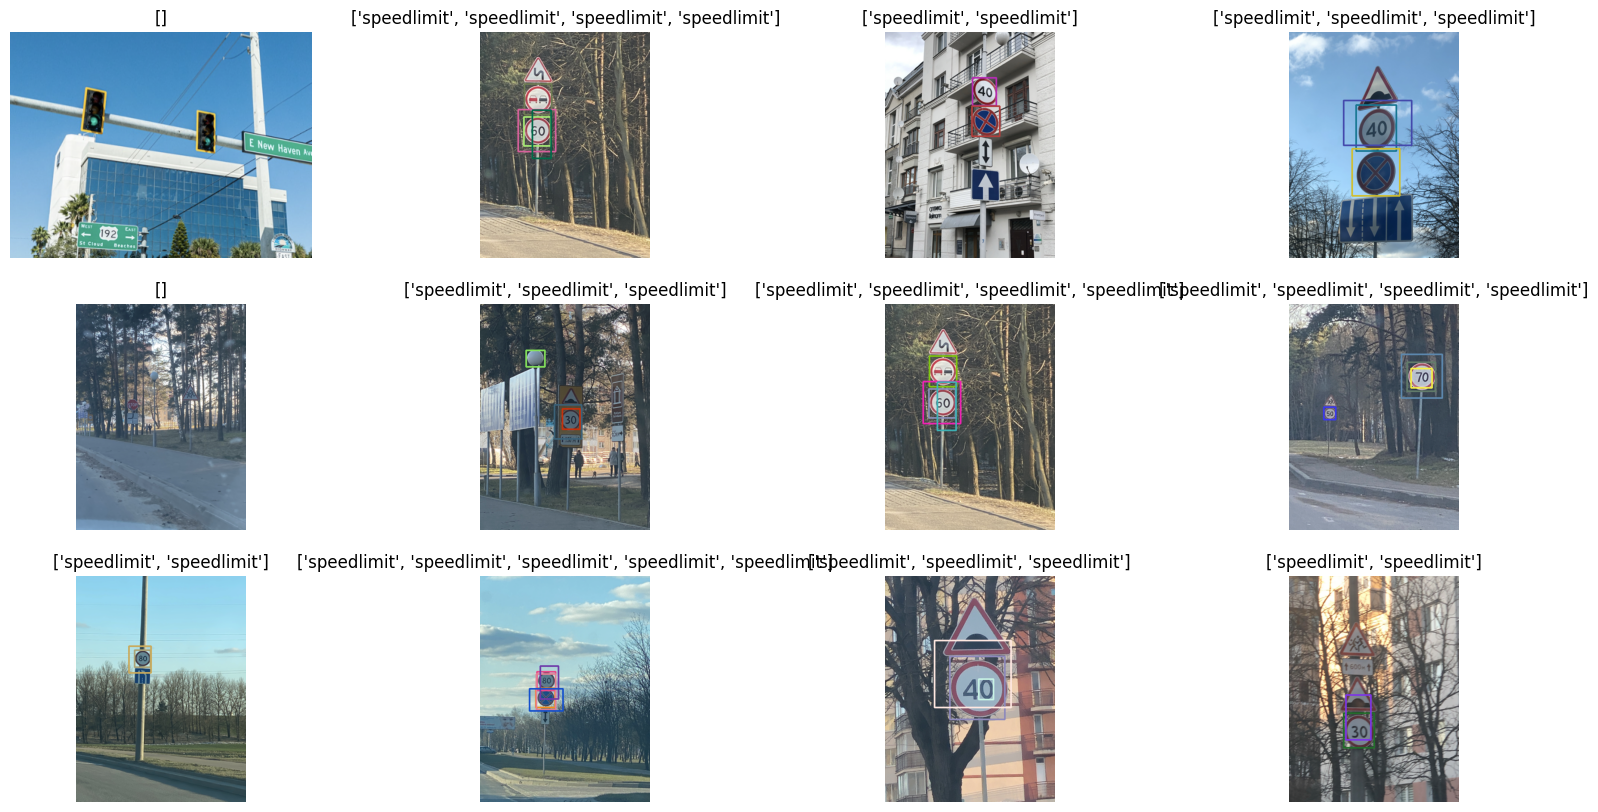

In [ ]:
def inference(model, ts_dl, num_ims, rows, threshold = 0.3, cmap = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(ts_dl) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):
        im, _ = ts_dl.dataset[indeks]
        with torch.no_grad(): predictions = m(im.unsqueeze(0).to(device))
        img = tensor_2_im(im, inv_trans = True)
        bbox_class_names = []
        for i, (boxes, scores, labels) in enumerate(zip(predictions[0]["boxes"], predictions[0]["scores"], predictions[0]["labels"])):
            if scores > threshold:
                bbox_class_names.append(list(class_names.keys())[labels.item()])
                r, g, b = [random.randint(0, 255) for _ in range(3)]
                x, y, w, h = [round(b.item()) for b in boxes]
                cv2.rectangle(img = img, pt1 = (x, y), pt2 = (w, h), color = (r, g, b), thickness = 2)
        plt.subplot(rows, num_ims // rows, idx + 1)
        plt.imshow(img); plt.title(f"{bbox_class_names}")
        plt.axis("off")

inference(model = m, ts_dl = ts_dl, num_ims = 12, rows = 3, cmap = "rgb")